In [1]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [6]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'dataset_summary')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [9]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/co

In [10]:
cases = [
    'C3L-00970',
    'C3L-00982',
    'C3L-01287',
    'C3L-02551'
]
case_to_mushroom = {c:Mushroom.from_config(os.path.join(project_dir, c, 'mushroom_50res'))
                   for c in cases}

INFO:root:loading spore for multiplex
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 29 channels
INFO:root:2 sections detected: ['C3L-00970-U2', 'C3L-00970-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00970-U2


0.02


INFO:root:generating image data for section C3L-00970-U2_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-00970-U2', 'multiplex'), ('C3L-00970-U2_dup', 'multiplex')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpl0nuokhu
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpl0nuokhu/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


multiplex torch.Size([29, 231, 217])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/multiplex_chkpts/last-v3.ckpt
INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:2 sections detected: ['C3L-00970-U1', 'C3L-00970-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00970-U1
INFO:root:generating image data for section C3L-00970-U1_dup


xenium torch.Size([477, 232, 218])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-00970-U1', 'xenium'), ('C3L-00970-U1_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/xenium_chkpts/last-v3.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve

Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['C3L-00982-U5', 'C3L-00982-U5_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U5


0.02


INFO:root:generating image data for section C3L-00982-U5_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-00982-U5', 'he'), ('C3L-00982-U5_dup', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/he_chkpts/last-v3.ckpt


he torch.Size([3, 274, 193])


INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 32 channels
INFO:root:3 sections detected: ['C3L-00982-U1', 'C3L-00982-U4', 'C3L-00982-U7']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U1


0.02


INFO:root:generating image data for section C3L-00982-U4
INFO:root:generating image data for section C3L-00982-U7
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('C3L-00982-U1', 'multiplex'), ('C3L-00982-U4', 'multiplex'), ('C3L-00982-U7', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/multiplex_chkpts/last-v3.ckpt


multiplex torch.Size([32, 274, 193])


INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:2 sections detected: ['C3L-00982-U2', 'C3L-00982-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U2
INFO:root:generating image data for section C3L-00982-U2_dup


xenium torch.Size([477, 275, 194])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-00982-U2', 'xenium'), ('C3L-00982-U2_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/xenium_chkpts/last-v2.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve perfor

Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:loading spore for multiplex
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 29 channels
INFO:root:2 sections detected: ['C3L-01287-U2', 'C3L-01287-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-01287-U2


0.02


INFO:root:generating image data for section C3L-01287-U2_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-01287-U2', 'multiplex'), ('C3L-01287-U2_dup', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/multiplex_chkpts/last-v2.ckpt
INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing


multiplex torch.Size([29, 217, 229])


INFO:root:using 477 channels
INFO:root:2 sections detected: ['C3L-01287-U1', 'C3L-01287-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-01287-U1
INFO:root:generating image data for section C3L-01287-U1_dup


xenium torch.Size([477, 218, 230])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-01287-U1', 'xenium'), ('C3L-01287-U1_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/xenium_chkpts/last-v2.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve

Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['C3L-02551-U7', 'C3L-02551-U7_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-02551-U7


0.02


INFO:root:generating image data for section C3L-02551-U7_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-02551-U7', 'he'), ('C3L-02551-U7_dup', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/he_chkpts/last-v2.ckpt
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing


he torch.Size([3, 144, 217])


INFO:root:using 32 channels
INFO:root:3 sections detected: ['C3L-02551-U1', 'C3L-02551-U4', 'C3L-02551-U8']
INFO:root:processing sections
INFO:root:generating image data for section C3L-02551-U1


0.02


INFO:root:generating image data for section C3L-02551-U4
INFO:root:generating image data for section C3L-02551-U8
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('C3L-02551-U1', 'multiplex'), ('C3L-02551-U4', 'multiplex'), ('C3L-02551-U8', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/multiplex_chkpts/last-v2.ckpt
INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing


multiplex torch.Size([32, 144, 217])


INFO:root:using 477 channels
INFO:root:2 sections detected: ['C3L-02551-U3', 'C3L-02551-U3_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-02551-U3
INFO:root:generating image data for section C3L-02551-U3_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-02551-U3', 'xenium'), ('C3L-02551-U3_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT


xenium torch.Size([477, 145, 218])


INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/xenium_chkpts/last-v2.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

In [11]:
mushroom = next(iter(case_to_mushroom.values()))

C3L-00970 multiplex 0


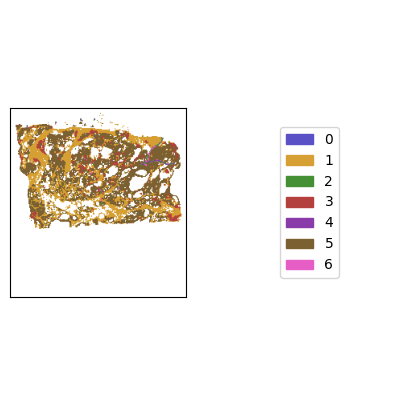

C3L-00970 multiplex 1


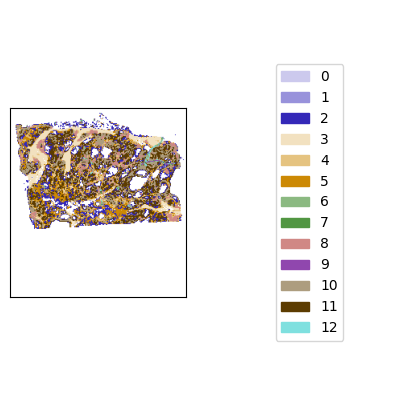

C3L-00970 multiplex 2


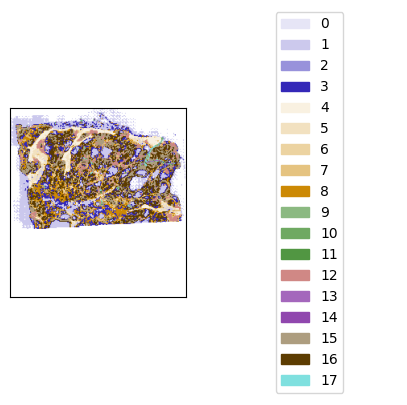

C3L-00970 xenium 0


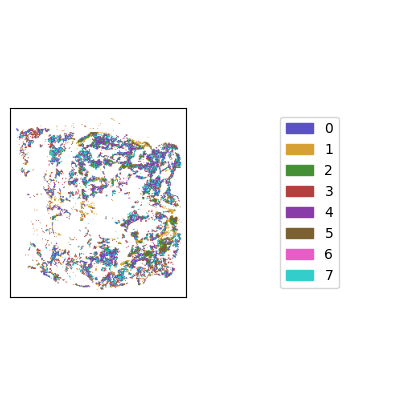

C3L-00970 xenium 1


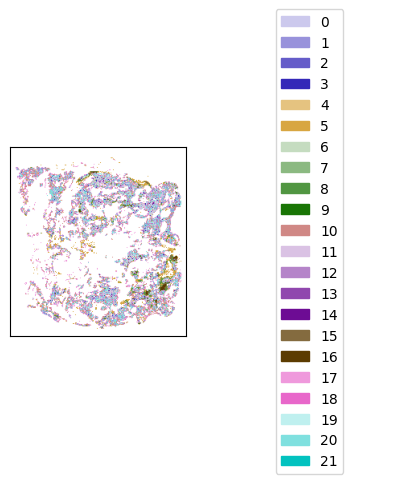

C3L-00970 xenium 2


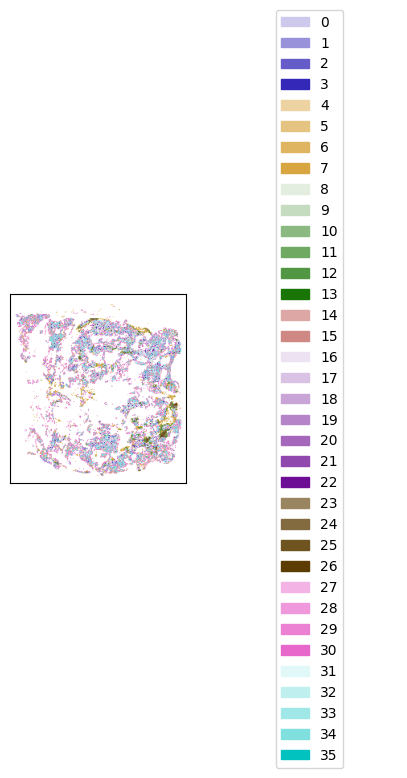

C3L-00982 he 0


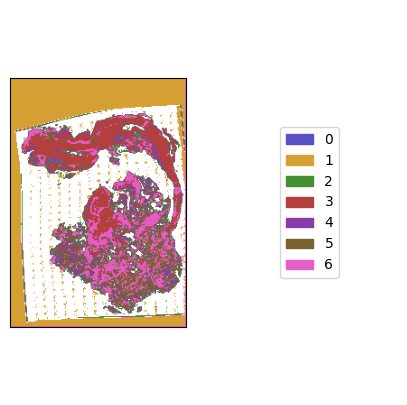

C3L-00982 he 1


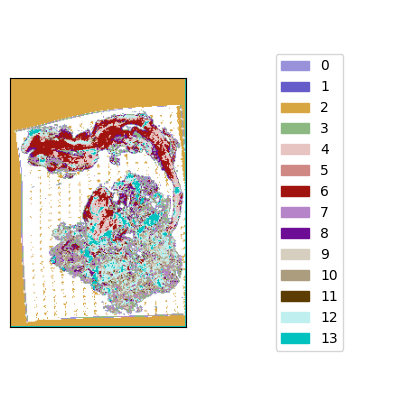

C3L-00982 he 2


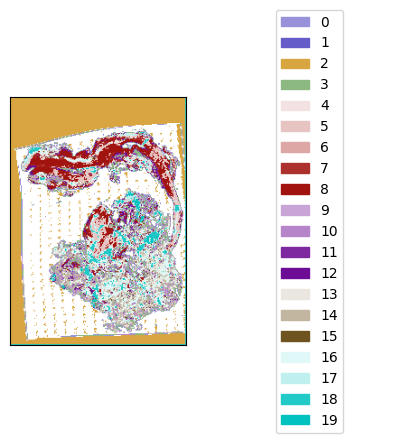

C3L-00982 multiplex 0


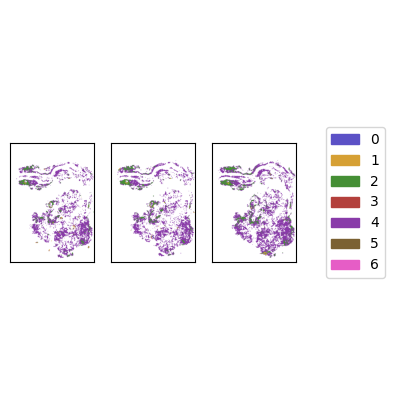

C3L-00982 multiplex 1


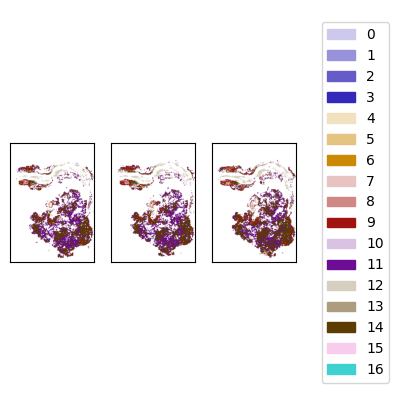

C3L-00982 multiplex 2


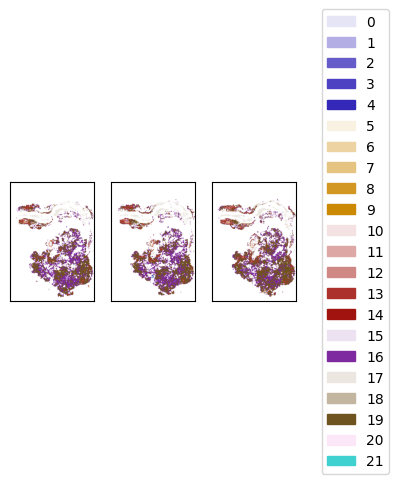

C3L-00982 xenium 0


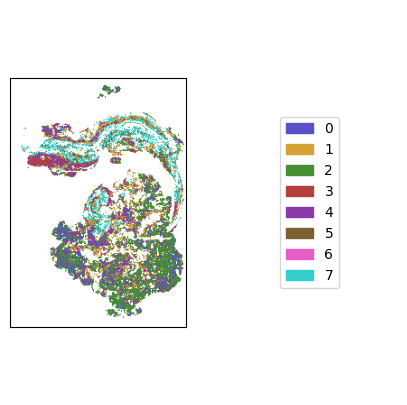

C3L-00982 xenium 1


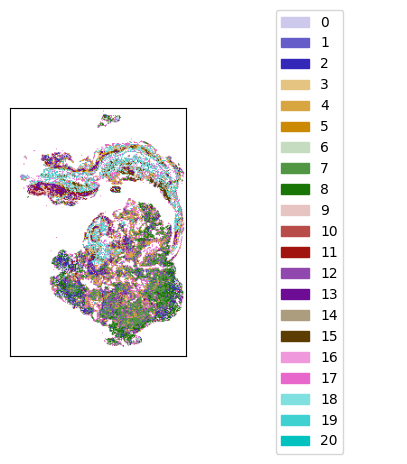

C3L-00982 xenium 2


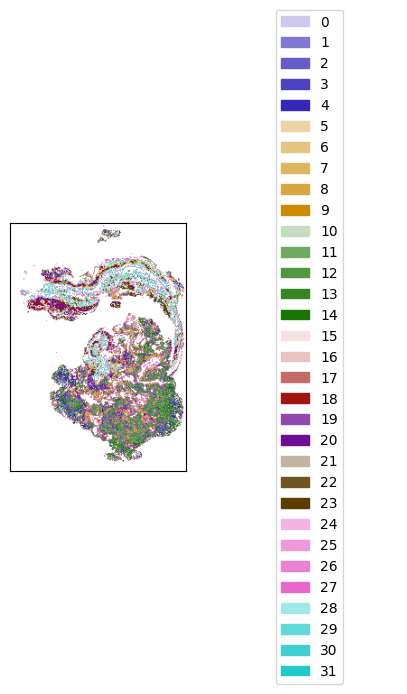

C3L-01287 multiplex 0


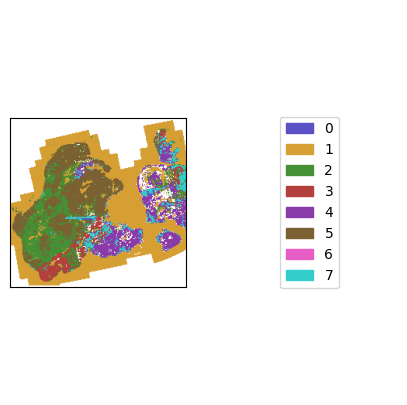

C3L-01287 multiplex 1


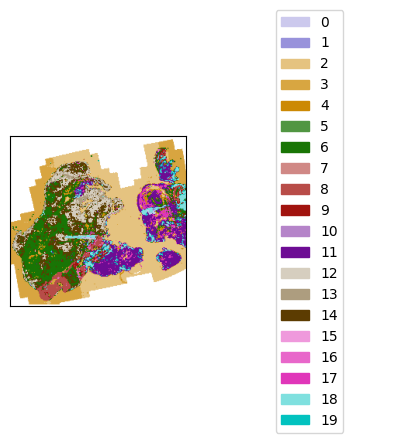

C3L-01287 multiplex 2


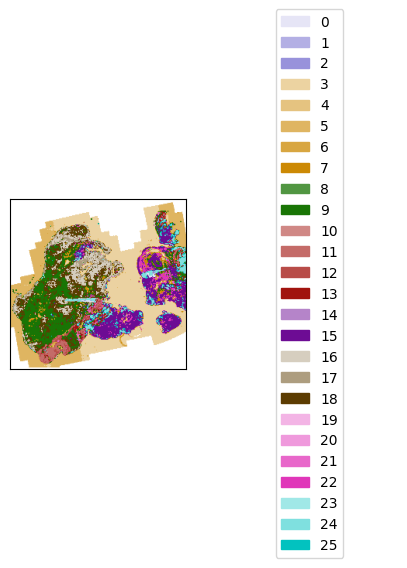

C3L-01287 xenium 0


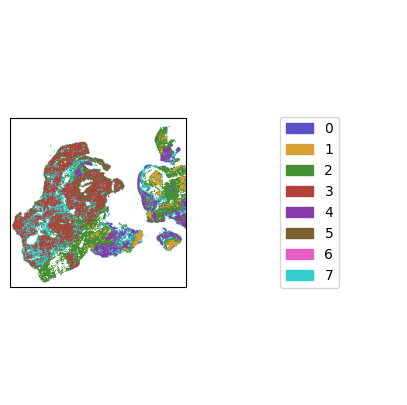

C3L-01287 xenium 1


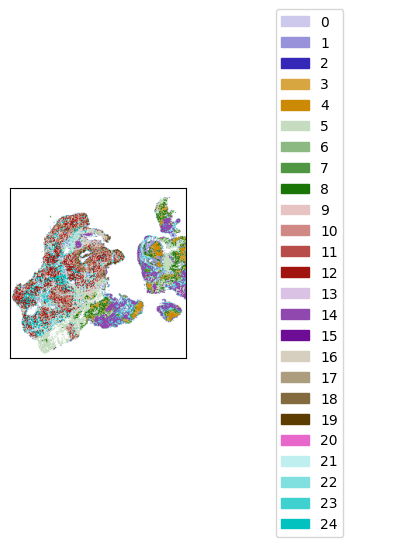

C3L-01287 xenium 2


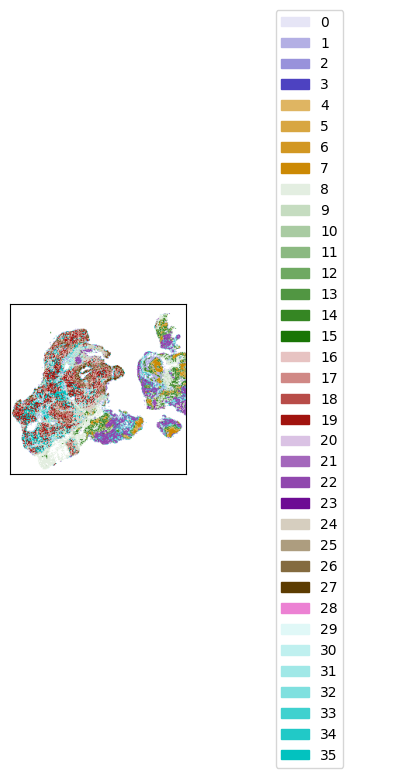

C3L-02551 he 0


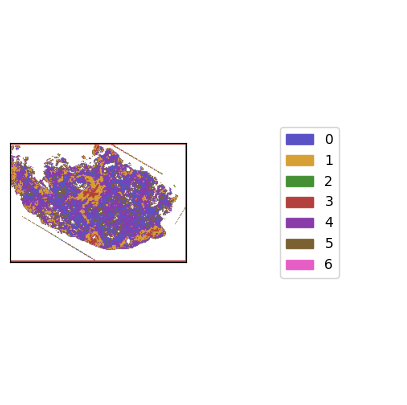

C3L-02551 he 1


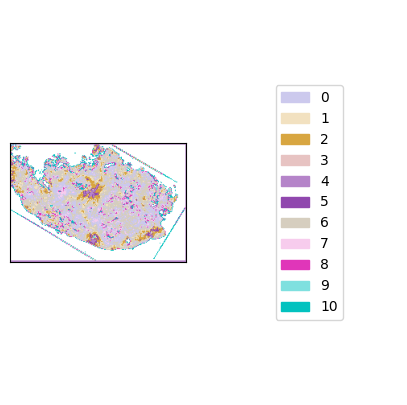

C3L-02551 he 2


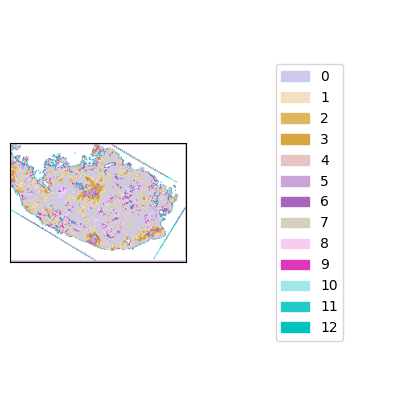

C3L-02551 multiplex 0


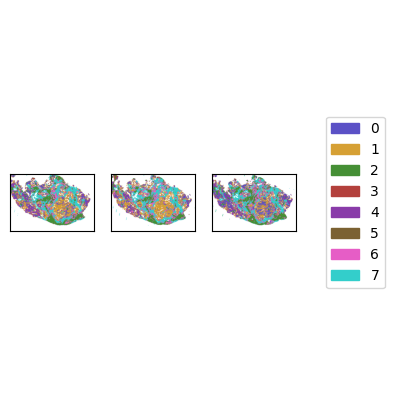

C3L-02551 multiplex 1


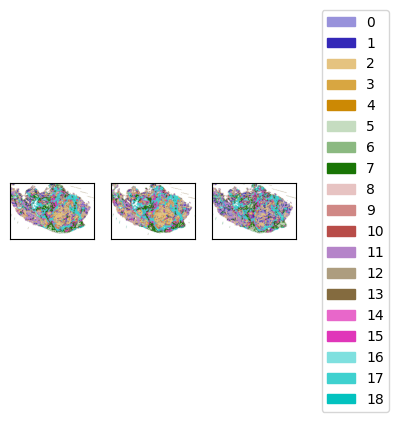

C3L-02551 multiplex 2


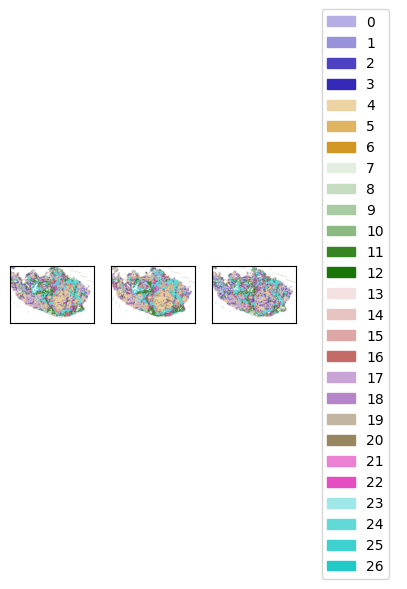

C3L-02551 xenium 0


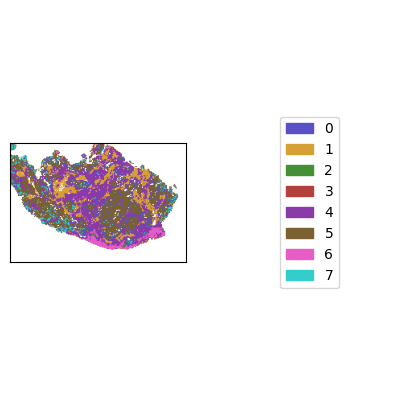

C3L-02551 xenium 1


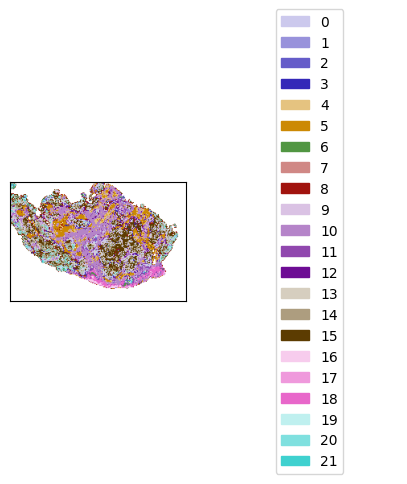

C3L-02551 xenium 2


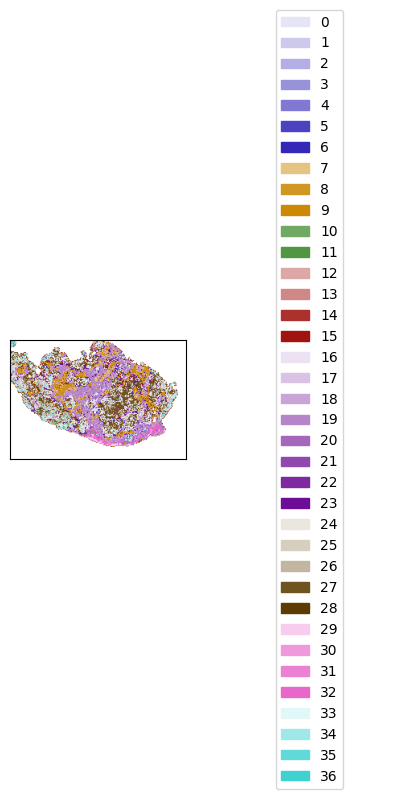

In [25]:
outs = '/data/estorrs/sandbox/ilya_mushroom_defaultcmap_whitebgd'
Path(outs).mkdir(parents=True, exist_ok=True)
for case, mushroom in case_to_mushroom.items():
    for dtype in mushroom.dtypes:
        for level in range(mushroom.num_levels):
            print(case, dtype, level)
#             mushroom.display_clusters(dtype, level=level, preserve_indices=True, figsize=(5, 5))
            mushroom.display_clusters(dtype, level=level, preserve_indices=True, figsize=(5, 5), use_hierarchy=True, discard_max=True)
            plt.savefig(os.path.join(outs, f'{case}_{dtype}_level{level}.svg'), dpi=300)
            plt.show()

In [18]:
ids, counts = np.unique(np.asarray([1,2,3,4,2,3,2,3,4,3,3,3]), return_counts=True, )
ids, counts

(array([1, 2, 3, 4]), array([1, 3, 6, 2]))

In [19]:
ids[counts.argmax()]

3

In [1]:
import mushroom.data.multiplex as multiplex

In [5]:
channel_to_img = multiplex.extract_ome_tiff('/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s1_HT397B1-U2_multiplex.ome.tiff', channels=['Pan-Cytokeratin'])
x = channel_to_img['Pan-Cytokeratin']
x.shape

(18640, 18380)

In [3]:
import tifffile

In [6]:
tifffile.imwrite('/data/estorrs/sandbox/panck.tif', x)